In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')

In [2]:
import numpy as np
from scipy.stats import spearmanr,kendalltau,permutation_test,kstest
from skimage.measure import regionprops
import h5py
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import rf_analyze_func as rfaf
import analyze_func as af
import plot_func as pf

# Open Naive .mat File

In [5]:
naive_data = {}

with h5py.File('/Volumes/Seagate Portable Drive/Augusto Data/Naive_RF_Data_Share.mat', 'r') as f:
    print(f.keys())
    for key in ['LayerID', 'Off', 'On', 'Simple','Resps']:
        if key=='#refs#': continue
        val = f[key][()].flatten()
        if val.dtype=='object':
            naive_data[key] = [f[ref][()] for ref in val]
        else:
            naive_data[key] = val

<KeysViewHDF5 ['#refs#', 'Exps', 'Filt_Stims', 'LayerID', 'Off', 'On', 'Resps', 'Simple', 'Stims', 'StimsExps', 'StimsInEachSeed']>


In [6]:
reload(rfaf)

for data_id in range(len(naive_data['LayerID'])):
    pix_len = 100/naive_data['On'][data_id].shape[0]
    
    naive_data['On'][data_id] =\
        rfaf.z_score_RF(naive_data['On'][data_id],pix_len,25)
    naive_data['Off'][data_id] =\
        rfaf.z_score_RF(naive_data['Off'][data_id],pix_len,25)
    naive_data['Simple'][data_id] =\
        rfaf.z_score_RF(naive_data['Simple'][data_id],pix_len,25)

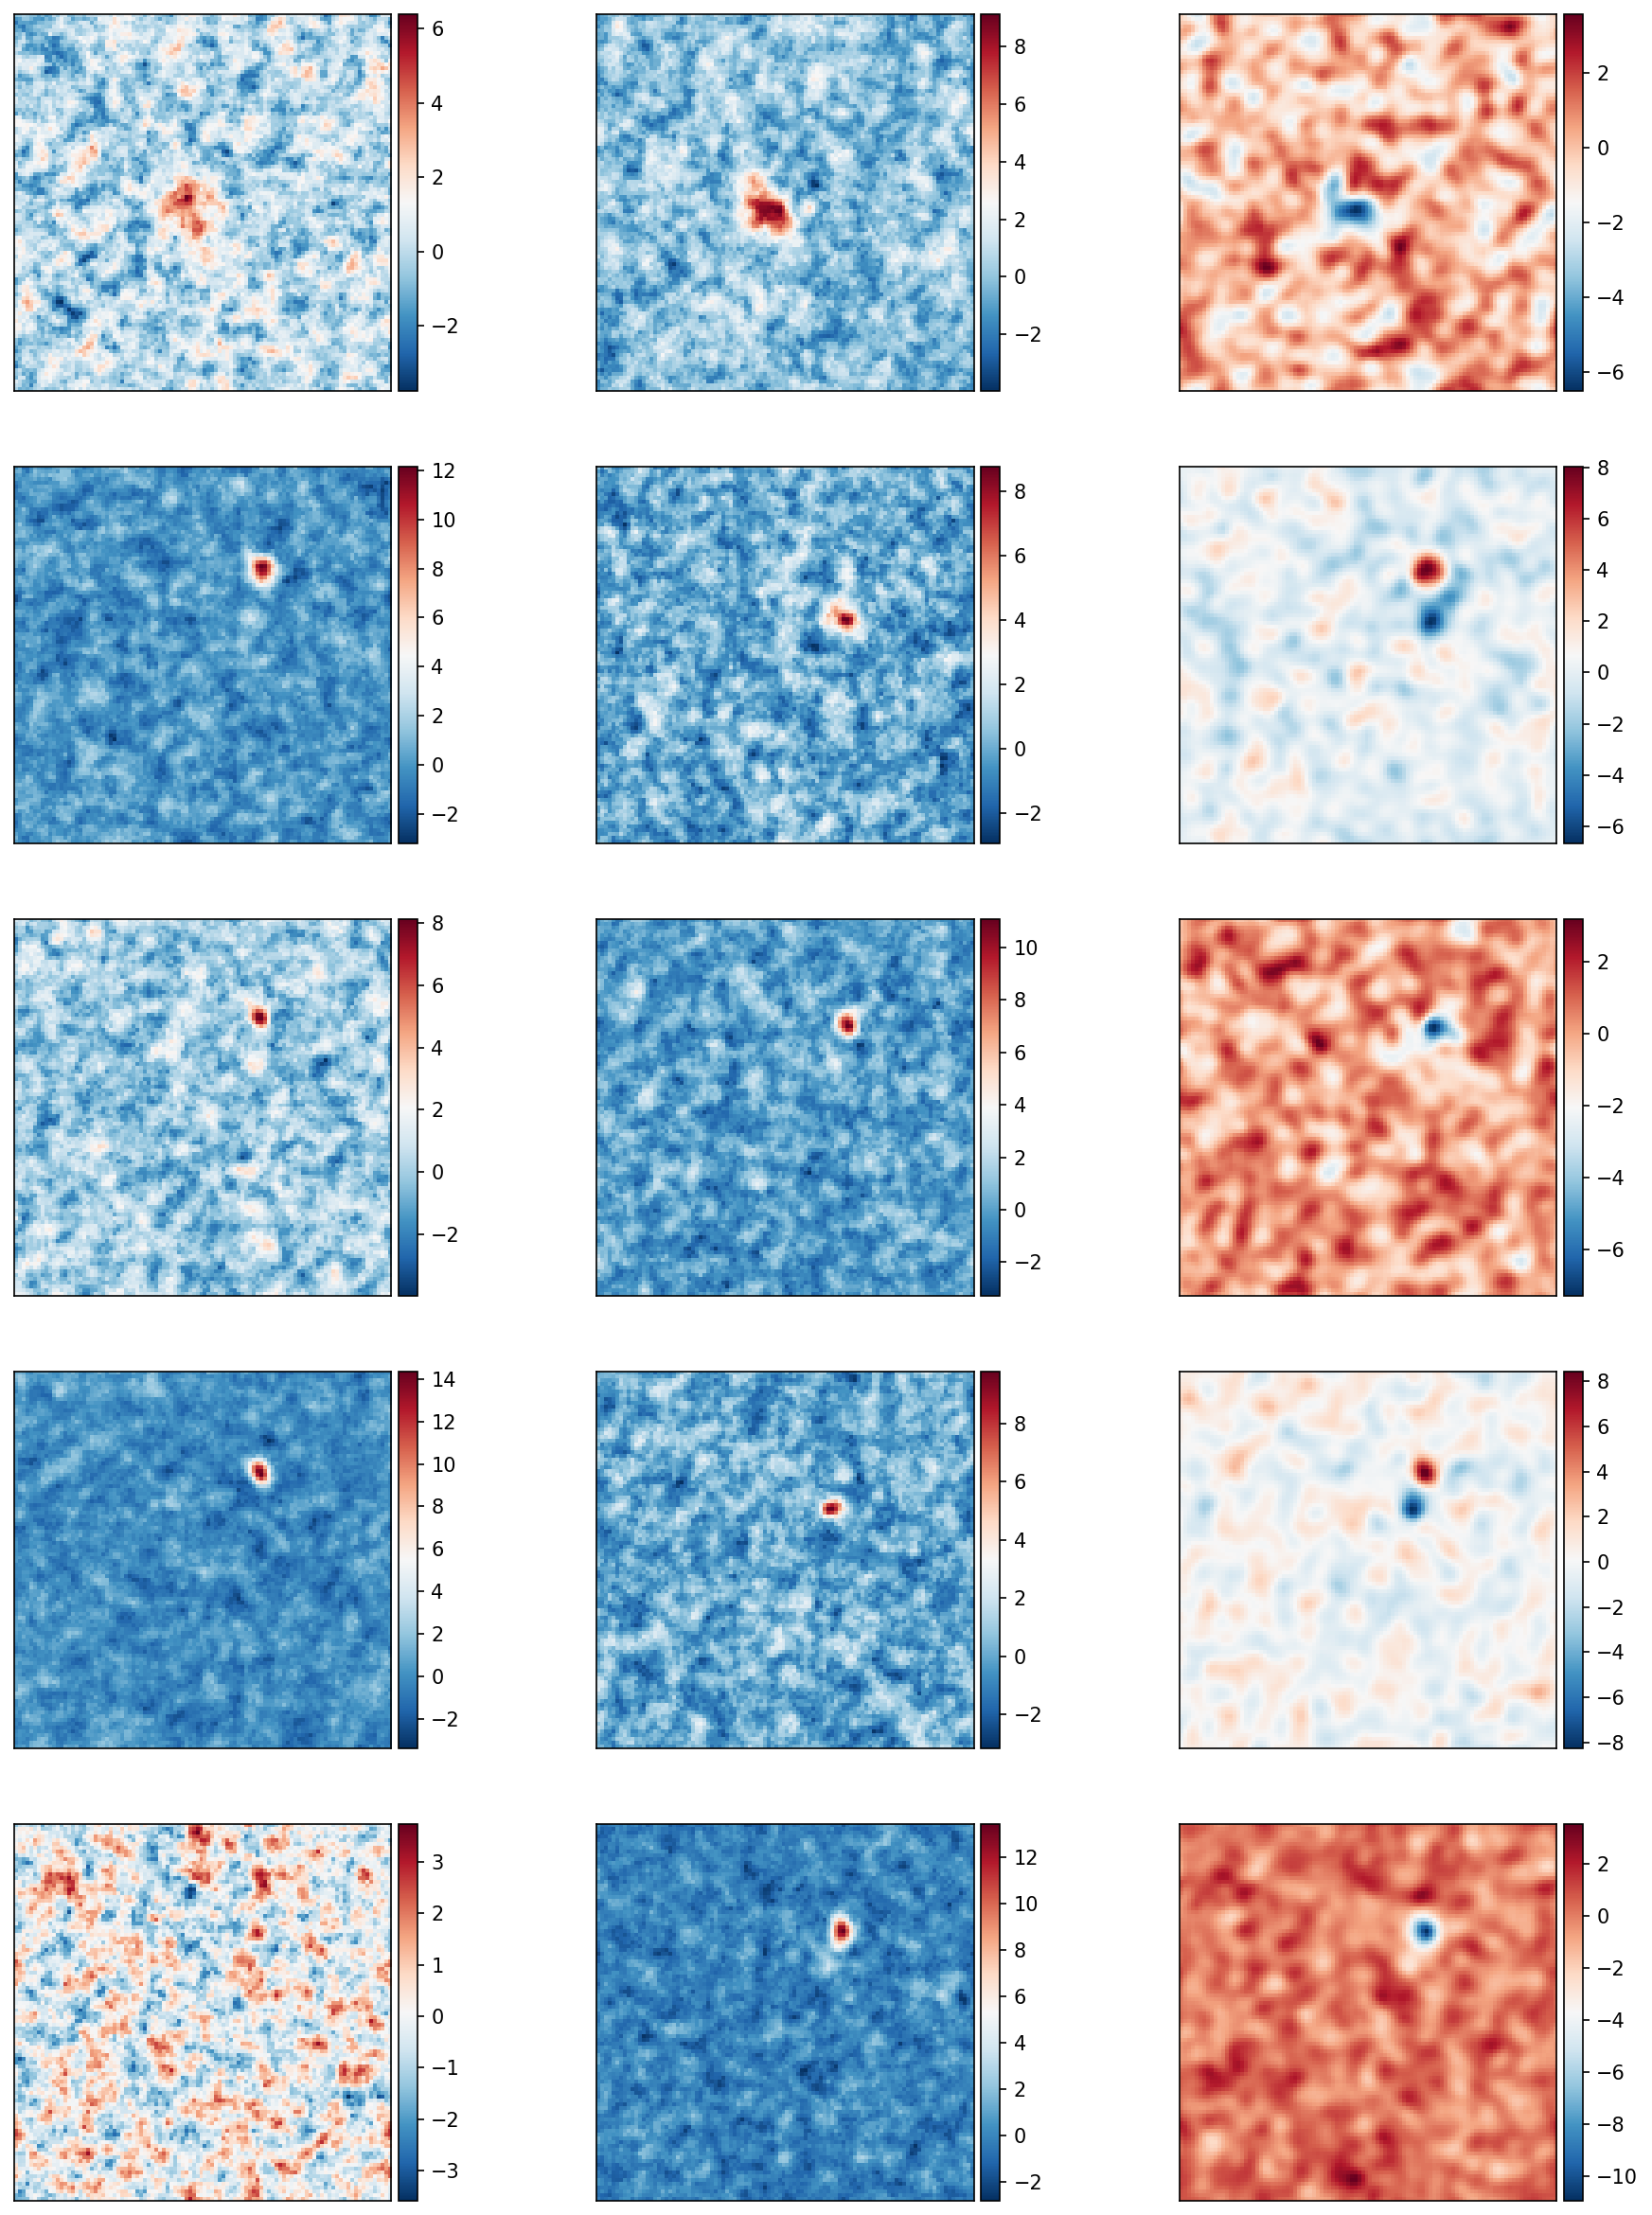

In [32]:
data_ids = np.arange(5)

fig,axs = plt.subplots(len(data_ids),3,figsize=(15,4*len(data_ids)),dpi=150)

for idx,data_id in enumerate(data_ids):
    pf.imshowbar(fig,axs[idx,0],naive_data['On'][data_id].T)
    pf.imshowbar(fig,axs[idx,1],naive_data['Off'][data_id].T)
    pf.imshowbar(fig,axs[idx,2],naive_data['Simple'][data_id].T)

In [7]:
N23 = np.count_nonzero(naive_data['LayerID']==1)
N4 = np.count_nonzero(naive_data['LayerID']==2)
N56 = np.count_nonzero(naive_data['LayerID']==3)

print(naive_data['LayerID'])
print('LayerID = 1 (L2/3):',N23)
print('LayerID = 2 (L4)  :',N4)
print('LayerID = 3 (L5/6):',N56)

[2. 1. 1. 1. 2. 2. 2. 2. 3. 3. 3. 2. 1. 3. 3. 1. 3. 2. 2. 3. 2. 2. 3. 1.
 1. 2. 2. 3. 3. 3. 1. 1. 2. 3. 3. 1. 1. 2. 3. 3. 3. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 3. 3. 3. 3. 3. 1. 2. 2. 1. 1. 1. 1. 2. 2. 3. 1. 1. 2. 3. 1. 1. 2.
 2. 1. 1. 2. 2. 2. 3.]
LayerID = 1 (L2/3): 22
LayerID = 2 (L4)  : 33
LayerID = 3 (L5/6): 24


In [8]:
reload(rfaf)

sig_cutoff = 2.5

L23_data = {'SR_ON': [],
            'SR_OF': [],
            'RF_ON': [],
            'RF_OF': []}
L4_data =  {'SR_ON': [],
            'SR_OF': [],
            'RF_ON': [],
            'RF_OF': []}
L56_data = {'SR_ON': [],
            'SR_OF': [],
            'RF_ON': [],
            'RF_OF': []}

for idx,layer in enumerate(naive_data['LayerID']):
    n = naive_data['On'][idx].shape[0]
    pix_len = 100/n
    
    # this_SR_ON,this_SR_OF = rfaf.binary_clean_RF((naive_data['On'][idx] > sig_cutoff).astype(int),
    #                                              (naive_data['Off'][idx]> sig_cutoff).astype(int),
    #                                              pix_len)
    # this_RF_ON,this_RF_OF = rfaf.binary_clean_RF((naive_data['Simple'][idx] > sig_cutoff).astype(int),
    #                                              (naive_data['Simple'][idx] <-sig_cutoff).astype(int),
    #                                              pix_len)
    # this_SR_ON,this_SR_OF = rfaf.center_rescale_RF((naive_data['On'][idx] > sig_cutoff).astype(int),
    #                                                (naive_data['Off'][idx]> sig_cutoff).astype(int),
    #                                                pix_len,rfaf.find_cent_idx(this_SR_ON+this_SR_OF),
    #                                                28,25,0.5)#32,30,0.5)
    # this_RF_ON,this_RF_OF = rfaf.center_rescale_RF((naive_data['Simple'][idx] > sig_cutoff).astype(int),
    #                                                (naive_data['Simple'][idx] <-sig_cutoff).astype(int),
    #                                                pix_len,rfaf.find_cent_idx(this_RF_ON+this_RF_OF),
    #                                                28,25,0.5)#32,30,0.5)
    
    this_SR_ON,this_SR_OF = np.zeros_like(naive_data['On'][idx]),np.zeros_like(naive_data['Off'][idx])
    np.copyto(this_SR_ON,naive_data['On'][idx] ,where=naive_data['On'][idx]  > sig_cutoff)
    np.copyto(this_SR_OF,naive_data['Off'][idx],where=naive_data['Off'][idx] > sig_cutoff)
    this_RF_ON,this_RF_OF = np.zeros_like(naive_data['Simple'][idx]),np.zeros_like(naive_data['Simple'][idx])
    np.copyto(this_RF_ON, naive_data['Simple'][idx],where=naive_data['Simple'][idx] >  sig_cutoff)
    np.copyto(this_RF_OF,-naive_data['Simple'][idx],where=naive_data['Simple'][idx] < -sig_cutoff)
    
    cent_idx = rfaf.find_cent_idx(np.add(*rfaf.binary_clean_RF((naive_data['On'][idx] > sig_cutoff).astype(int),
                                                               (naive_data['Off'][idx]> sig_cutoff).astype(int),
                                                               pix_len)))
    this_SR_ON,this_SR_OF = rfaf.center_rescale_RF(this_SR_ON,
                                                   this_SR_OF,
                                                   pix_len,cent_idx,28,25,0.5)#32,30,0.5)
    cent_idx = rfaf.find_cent_idx(np.add(*rfaf.binary_clean_RF((naive_data['Simple'][idx] > sig_cutoff).astype(int),
                                                               (naive_data['Simple'][idx] <-sig_cutoff).astype(int),
                                                               pix_len)))
    this_RF_ON,this_RF_OF = rfaf.center_rescale_RF(this_RF_ON,
                                                   this_RF_OF,
                                                   pix_len,cent_idx,28,25,0.5)#32,30,0.5)
    if layer==1:
        this_dict = L23_data
    elif layer==2:
        this_dict = L4_data
    else:
        this_dict = L56_data
    
    this_dict['SR_ON'].append(this_SR_ON)
    this_dict['SR_OF'].append(this_SR_OF)
    this_dict['RF_ON'].append(this_RF_ON)
    this_dict['RF_OF'].append(this_RF_OF)

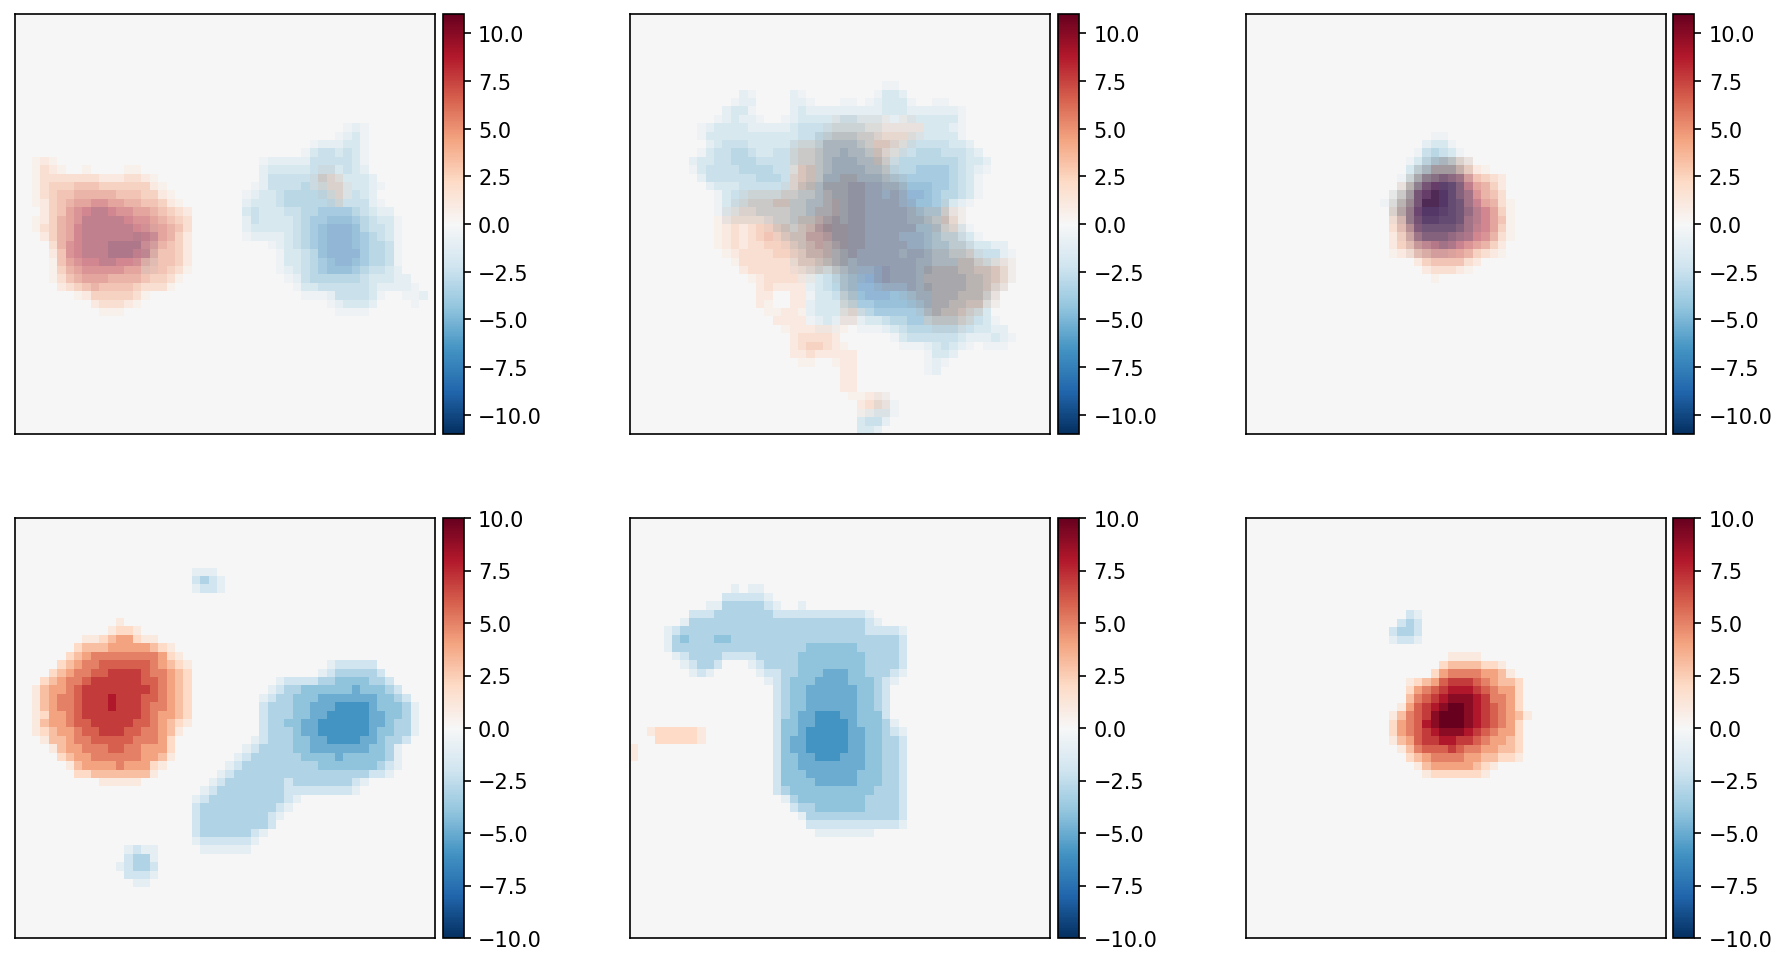

In [63]:
data_ids = [0,0,0]

fig,axs = plt.subplots(2,3,figsize=(15,8),dpi=150)

for idx,Ldict in enumerate([L23_data,L4_data,L56_data]):
    pf.doubimshbar(fig,axs[0,idx],Ldict['SR_ON'][data_ids[idx]],
                   -Ldict['SR_OF'][data_ids[idx]],vmin=-10,vmax=10)
    pf.imshowbar(fig,axs[1,idx],Ldict['RF_ON'][data_ids[idx]]-\
                 Ldict['RF_OF'][data_ids[idx]],vmin=-10,vmax=10)

In [9]:
for Ldict,Lsize in zip([L23_data,L4_data,L56_data],[N23,N4,N56]):
    this_sepr = np.zeros(Lsize)
    this_bias = np.zeros(Lsize)
    this_dist = np.zeros(Lsize)
    this_onar = np.zeros(Lsize)
    this_ofar = np.zeros(Lsize)
    this_totar = np.zeros(Lsize)
    this_bigcirc = np.zeros(Lsize)
    
    for idx in range(Lsize):
        # this_SR_ON = Ldict['SR_ON'][idx]
        # this_SR_OF = Ldict['SR_OF'][idx]
        this_SR_ON = (Ldict['SR_ON'][idx] > 1).astype(int)
        this_SR_OF = (Ldict['SR_OF'][idx] > 1).astype(int)
        
        this_sepr[idx] = 1-np.abs((this_SR_ON+this_SR_OF)==2).sum((-2,-1)) /\
            np.fmin(this_SR_ON.sum((-2,-1)),this_SR_OF.sum((-2,-1)))
        if np.isnan(this_sepr[idx]):
            this_sepr[idx] = 1
        this_bias[idx] = np.abs((this_SR_ON-this_SR_OF).sum((-2,-1))) /\
            (this_SR_ON+this_SR_OF).sum((-2,-1))
        if np.sum(this_SR_ON)*0.25 > 15:
            props = regionprops(this_SR_ON)[0]
            on_cent = props['centroid']
        else:
            on_cent = [np.nan,np.nan]
        if np.sum(this_SR_OF)*0.25 > 15:
            props = regionprops(this_SR_OF)[0]
            of_cent = props['centroid']
        else:
            of_cent = [np.nan,np.nan]
        if np.sum(this_SR_ON) > np.sum(this_SR_OF):
            props = regionprops(this_SR_ON)[0]
        else:
            props = regionprops(this_SR_OF)[0]
        this_dist[idx] = np.sqrt((on_cent[0]-of_cent[0])**2+(on_cent[1]-of_cent[1])**2)*0.5
        this_onar[idx] = this_SR_ON.sum((-2,-1))*0.25
        this_ofar[idx] = this_SR_OF.sum((-2,-1))*0.25
        this_totar[idx] = this_onar[idx] + this_ofar[idx]
        this_bigcirc[idx] = props['axis_minor_length']/props['axis_major_length']
    
    Ldict['sepr'] = this_sepr
    Ldict['bias'] = this_bias
    Ldict['dist'] = this_dist
    Ldict['onar'] = this_onar
    Ldict['ofar'] = this_ofar
    Ldict['totar'] = this_totar
    Ldict['bigcirc'] = this_bigcirc

/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_77018/2599639614.py:16: RuntimeWarning: invalid value encountered in scalar divide
  this_sepr[idx] = 1-np.abs((this_SR_ON+this_SR_OF)==2).sum((-2,-1)) /\


In [10]:
noris = 8
nphss = 16

freq = 0.06

ngrid = 50

grates = np.zeros((noris,nphss,ngrid,ngrid))

xs,ys = np.meshgrid(np.arange(ngrid)*0.5,np.arange(ngrid)*0.5)

for i in range(noris):
    ori = i/noris*np.pi
    for j in range(nphss):
        phs = j/nphss*2*np.pi
        grates[i,j] = np.heaviside(np.cos(phs+2*np.pi*freq*(np.cos(ori)*xs+np.sin(ori)*ys)),0.5)

In [11]:
for Ldict,Lsize in zip([L23_data,L4_data,L56_data],[N23,N4,N56]):
    this_SR_resp = [None]*Lsize
    
    for idx in range(Lsize):
        this_SR_ON = Ldict['SR_ON'][idx]
        this_SR_OF = Ldict['SR_OF'][idx]

        this_SR_resp[idx] = np.sum(grates*this_SR_ON[None,None,:,:]+\
                            (1-grates)*this_SR_OF[None,None,:,:],(-2,-1))
        this_SR_resp[idx] = np.fmax(0,this_SR_resp[idx] - np.mean(this_SR_resp[idx]))
    
    this_SR_resp = np.array(this_SR_resp)
    this_SR_OS,this_SR_MR = af.calc_OS_MR(this_SR_resp)
    
    Ldict['SR_resp'] = this_SR_resp
    Ldict['SR_OS'] = this_SR_OS
    Ldict['SR_MR'] = this_SR_MR

In [73]:
print(np.nanmax(np.concatenate([L23_data['dist'],L4_data['dist'],L56_data['dist']])))
print(np.nanmax(np.concatenate([L23_data['totar'],L4_data['totar'],L56_data['totar']])))

11.650705166976989
320.0


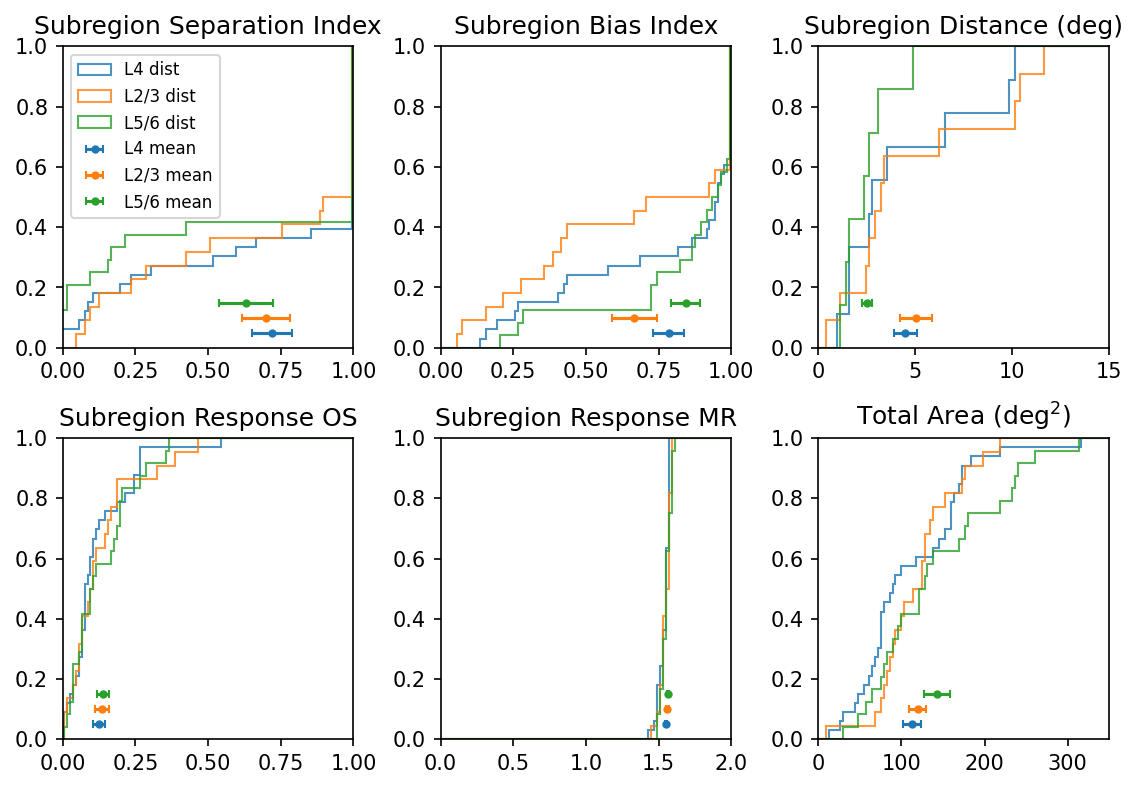

In [94]:
nbins = 100

fig,axs = plt.subplots(2,3,figsize=(9,6),dpi=150)
fig.subplots_adjust(wspace=0.3,hspace=0.3)
axs = axs.ravel()

for col_idx,key,data_max,col_label in zip(range(6),['sepr','bias','dist','SR_OS','SR_MR','totar'],
                                          [1,1,15,1,2,350],
                                          ['Subregion Separation Index','Subregion Bias Index',
                                           'Subregion Distance (deg)','Subregion Response OS',
                                           'Subregion Response MR',r'Total Area (deg${}^2$)']):
    for Lidx,Ldict,Lsize,Llabel in zip(range(3),[L4_data,L23_data,L56_data],[N4,N23,N56],
                                       ['L4','L2/3','L5/6']):
        axs[col_idx].hist(Ldict[key],np.linspace(-data_max/(2*nbins),data_max+data_max/(2*nbins),2+nbins),
                                  density=True,cumulative=True,histtype='step',
                                  color='C{:d}'.format(Lidx),alpha=0.8,label=Llabel+' dist')

        axs[col_idx].errorbar(np.nanmean(Ldict[key]),(Lidx+1)*0.05,
                              xerr=np.nanstd(Ldict[key])/np.sqrt(Lsize-1),
                              color='C{:d}'.format(Lidx),fmt='.',capsize=2,label=Llabel+' mean')
    
    axs[col_idx].set_xlim(0,data_max)
    axs[col_idx].set_ylim(0,1)
    axs[col_idx].set_title(col_label)
    
axs[0].legend(fontsize=8)

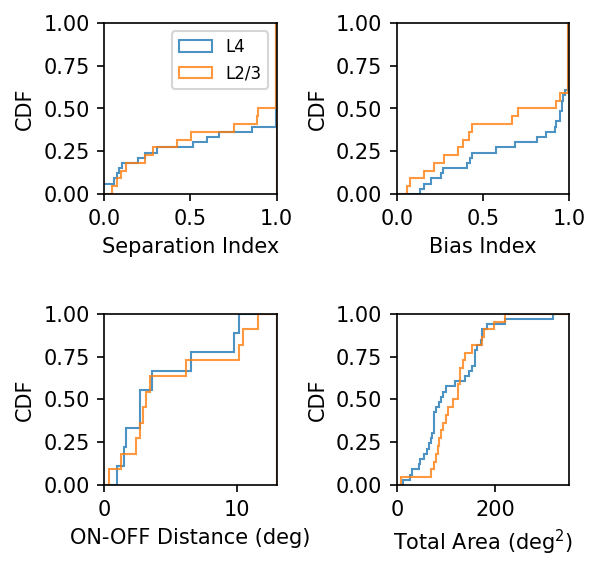

In [103]:
nbins = 100

fig,axs = plt.subplots(2,2,figsize=(4,4),dpi=150)
fig.subplots_adjust(wspace=0.7,hspace=0.7)
axs = axs.ravel()

for col_idx,key,data_max,col_label in zip(range(6),['sepr','bias','dist','totar'],
                                          [1,1,13,350],
                                          ['Separation Index','Bias Index',
                                           'ON-OFF Distance (deg)',r'Total Area (deg${}^2$)']):
    for Lidx,Ldict,Lsize,Llabel in zip(range(3),[L4_data,L23_data],[N4,N23],
                                       ['L4','L2/3']):
        axs[col_idx].hist(Ldict[key],np.linspace(-data_max/(2*nbins),data_max+data_max/(2*nbins),2+nbins),
                                  density=True,cumulative=True,histtype='step',
                                  color='C{:d}'.format(Lidx),alpha=0.8,label=Llabel)

        # axs[col_idx].errorbar(np.nanmean(Ldict[key]),(Lidx+1)*0.05,
        #                       xerr=np.nanstd(Ldict[key])/np.sqrt(Lsize-1),
        #                       color='C{:d}'.format(Lidx),fmt='.',capsize=2,label=Llabel+' mean')
    
    axs[col_idx].set_xlim(0,data_max)
    axs[col_idx].set_ylim(0,1)
    axs[col_idx].set_xlabel(col_label)
    axs[col_idx].set_ylabel('CDF')
    
axs[0].legend(fontsize=8)

# fig.savefig('./../plots/CosyneFigure_1.pdf',dpi=300)

In [13]:
L23_data['EP_OS'] = np.array([0.4760528723,0.3308279703,0.3223525826,0.3264914623,0.2191160552,0.2670176327,0.3934186142,0.5228838893,0.6576787437,0.3152900944,0.2300845088,0.2879100778,0.1286789543,0.156303277,0.3726522291,0.222508609,0.06290847508,0.2997602291,0.4645211984,0.3479613676,0.3658606169,0.2790871587,0.2034199102,0.1324653136,0.1105581452,0.4530480435,0.3046028612,0.2753179159,0.2895791202,0.1385549466,0.09273950353,0.1029055413,0.1297276592,0.3382020946,0.3014209066,0.1634362917,0.2201820087,0.5803249244,0.211787448,0.2601471123,0.4590994767,0.3340753884])
L23_data['EP_MR'] = np.array([0.1623575659,0.05879047185,0.3198470798,0.2099709291,0.6890895375,0.3269520803,0.7561768304,0.747605961,0.2836139831,0.5082253003,0.606038747,0.3097853269,0.8872722254,0.1658928953,0.7847403221,0.3472182434,0.3299478361,0.9292291885,0.2322139092,0.3371157299,0.6676644707,0.7243157734,0.5829558928,0.678180949,0.8193948157,0.2642680126,1.057557743,0.3023558407,0.110159821,1.019013221,0.5683430573,1.379353468,0.6594113705,0.716423324,0.6857107651,0.3122903688,0.3420403137,0.8910184375,0.7644300107,0.6909518987,0.2993528204,0.7997260236])

L4_data['EP_OS'] = np.array([0.1194864161,0.1525679935,0.4874608911,0.1602774903,0.1135888739,0.06703226326,0.2536722445,0.2177989474,0.09716525651,0.03831831073,0.2660086059,0.08905891804,0.1688203565,0.1639439702,0.1382016261,0.09940273834,0.04530679464,0.1770105479,0.05676717173,0.1314834953,0.1962750815,0.08812243301,0.08857312978,0.2550182647,0.02655808307,0.2246883286,0.1381629738,0.06884612782,0.6763916662,0.2816100845,0.06381390939,0.03777911662])
L4_data['EP_MR'] = np.array([1.429275541,0.9966617649,0.4300636681,0.4753921161,0.333099888,0.3477431124,0.5499137837,0.03472418284,1.253581303,0.1818181818,0.8188426414,0.7071452199,1.631316093,0.2324873054,0.7454389391,0.732799123,0.5291057862,1.230214831,0.2716490582,0.7549452965,0.3782131785,0.2386198008,0.5080813638,1.913991385,0.4691310464,0.6472135955,0.531972272,0.9647422213,0.3663468105,0.4852765568,0.1302685025,0.1624876421])

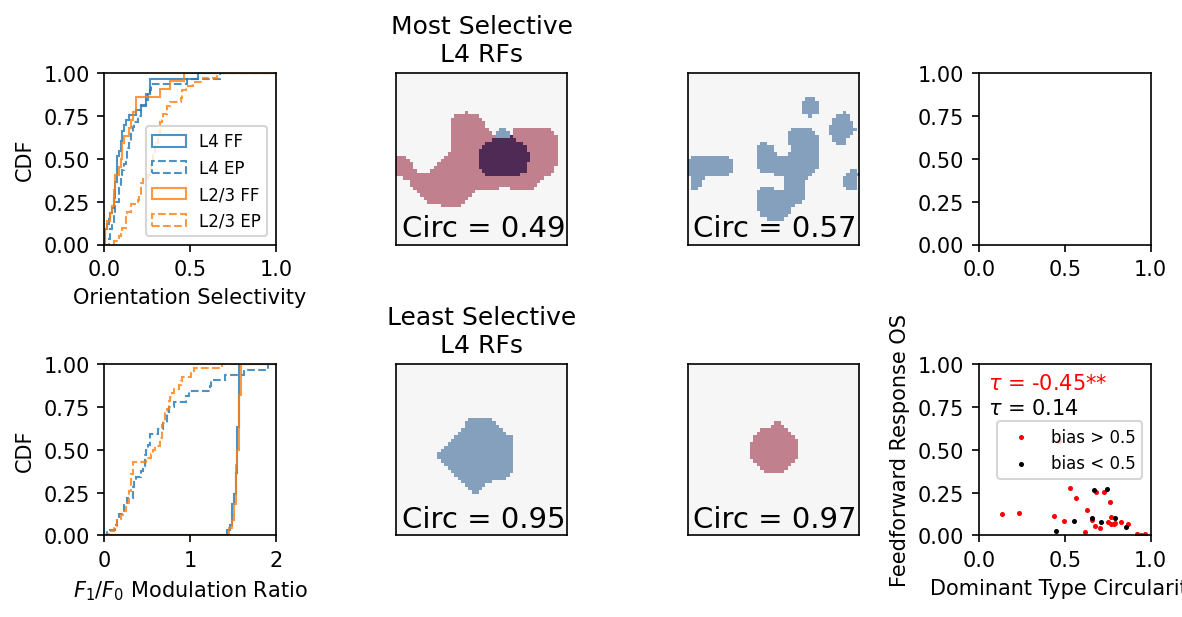

In [212]:
nbins = 100

fig,axs = plt.subplots(2,4,figsize=(9,4),dpi=150)
fig.subplots_adjust(wspace=0.7,hspace=0.7)

for col_idx,key,data_max,col_label in zip(range(6),[['SR_OS','EP_OS'],['SR_MR','EP_MR']],
                                          [1,2],
                                          ['Orientation Selectivity',
                                           r'$F_1/F_0$ Modulation Ratio']):
    for Lidx,Ldict,Lsize,Llabel in zip(range(3),[L4_data,L23_data],[N4,N23],
                                       ['L4','L2/3']):
        axs[col_idx,0].hist(Ldict[key[0]],np.linspace(-data_max/(2*nbins),data_max+data_max/(2*nbins),2+nbins),
                                  density=True,cumulative=True,histtype='step',
                                  color='C{:d}'.format(Lidx),alpha=0.8,label=Llabel+' FF')
        axs[col_idx,0].hist(Ldict[key[1]],np.linspace(-data_max/(2*nbins),data_max+data_max/(2*nbins),2+nbins),
                                  density=True,cumulative=True,histtype='step',
                                  color='C{:d}'.format(Lidx),ls='--',alpha=0.8,label=Llabel+' EP')

        # axs[col_idx].errorbar(np.nanmean(Ldict[key]),(Lidx+1)*0.05,
        #                       xerr=np.nanstd(Ldict[key])/np.sqrt(Lsize-1),
        #                       color='C{:d}'.format(Lidx),fmt='.',capsize=2,label=Llabel+' mean')
    
    axs[col_idx,0].set_xlim(0,data_max)
    axs[col_idx,0].set_ylim(0,1)
    axs[col_idx,0].set_xlabel(col_label)
    axs[col_idx,0].set_ylabel('CDF')
    
axs[0,0].legend(fontsize=8)

for idx in range(2):
    data_id = np.argsort(L4_data['SR_OS'])[-(idx+1)]
    pf.doubimsh(fig,axs[0,idx+1],np.fmin(1,L4_data['SR_ON'][data_id]),
                -np.fmin(1,L4_data['SR_OF'][data_id]),
                cmap_name='RdBu',origin='lower',vmin=-1,vmax=1)
    if np.sum((L4_data['SR_ON'][data_id] > 0).astype(int)) > np.sum((L4_data['SR_OF'][data_id] > 0).astype(int)):
        props = regionprops((L4_data['SR_ON'][data_id] > 0).astype(int))[0]
    else:
        props = regionprops((L4_data['SR_OF'][data_id] > 0).astype(int))[0]
    crc = props['axis_minor_length']/props['axis_major_length']
    axs[0,idx+1].text(25,2,'Circ = {:.2f}'.format(crc),ha='center',fontsize=14)

axs[0,1].set_title('Most Selective\nL4 RFs')

for idx in range(2):
    data_id = np.argsort(L4_data['SR_OS'])[idx]
    pf.doubimsh(fig,axs[1,idx+1],np.fmin(1,L4_data['SR_ON'][data_id]),
                -np.fmin(1,L4_data['SR_OF'][data_id]),
                cmap_name='RdBu',origin='lower',vmin=-1,vmax=1)
    if np.sum((L4_data['SR_ON'][data_id] > 0).astype(int)) > np.sum((L4_data['SR_OF'][data_id] > 0).astype(int)):
        props = regionprops((L4_data['SR_ON'][data_id] > 0).astype(int))[0]
    else:
        props = regionprops((L4_data['SR_OF'][data_id] > 0).astype(int))[0]
    crc = props['axis_minor_length']/props['axis_major_length']
    axs[1,idx+1].text(25,2,'Circ = {:.2f}'.format(crc),ha='center',fontsize=14)

axs[1,1].set_title('Least Selective\nL4 RFs')

bias_idx = L4_data['bias'] > 0.5
unbias_idx = L4_data['bias'] < 0.5
axs[1,3].scatter(L4_data['bigcirc'][bias_idx],L4_data['SR_OS'][bias_idx],s=2,c='r',label='bias > 0.5')
taustat = kendalltau(L4_data['bigcirc'][bias_idx],L4_data['SR_OS'][bias_idx])
axs[1,3].text(0.05,0.95,r'$\tau$ = {:.2f}**'.format(taustat.statistic,taustat.pvalue),
              color='r',ha='left',va='top')
axs[1,3].scatter(L4_data['bigcirc'][unbias_idx],L4_data['SR_OS'][unbias_idx],s=2,c='k',label='bias < 0.5')
taustat = kendalltau(L4_data['bigcirc'][unbias_idx],L4_data['SR_OS'][unbias_idx])
axs[1,3].text(0.05,0.80,r'$\tau$ = {:.2f}'.format(taustat.statistic,taustat.pvalue),
              color='k',ha='left',va='top')

axs[1,3].set_xlim(0,1)
axs[1,3].set_ylim(0,1)
axs[1,3].set_xlabel('Dominant Type Circularity')
axs[1,3].set_ylabel('Feedforward Response OS')

axs[1,3].legend(fontsize=8)

# fig.savefig('./../plots/CosyneFigure_2.pdf',dpi=300)

In [213]:
taustat = kendalltau(L4_data['bigcirc'][bias_idx],L4_data['SR_OS'][bias_idx])
print(taustat.pvalue)
taustat = kendalltau(L4_data['bigcirc'][unbias_idx],L4_data['SR_OS'][unbias_idx])
print(taustat.pvalue)

0.00118256899300539
0.7195436507936508


In [206]:
print(taustat.pvalue)

0.7195436507936508


In [15]:
print('L4   FF vs EP OS:',kstest( L4_data['SR_OS'], L4_data['EP_OS']))
print('L2/3 FF vs EP OS:',kstest(L23_data['SR_OS'],L23_data['EP_OS']))
print('L4 vs L2/3 FF OS:',kstest( L4_data['SR_OS'],L23_data['SR_OS']))
print()
print('L4   FF vs EP MR:',kstest( L4_data['SR_MR'], L4_data['EP_MR']))
print('L2/3 FF vs EP MR:',kstest(L23_data['SR_MR'],L23_data['EP_MR']))
print('L4 vs L2/3 FF MR:',kstest( L4_data['SR_MR'],L23_data['SR_MR']))

L4   FF vs EP OS: KstestResult(statistic=np.float64(0.26515151515151514), pvalue=np.float64(0.1550152074317178), statistic_location=np.float64(0.08313075538233794), statistic_sign=np.int8(1))
L2/3 FF vs EP OS: KstestResult(statistic=np.float64(0.6255411255411255), pvalue=np.float64(8.277684781961167e-06), statistic_location=np.float64(0.19155492074036548), statistic_sign=np.int8(1))
L4 vs L2/3 FF OS: KstestResult(statistic=np.float64(0.15151515151515152), pvalue=np.float64(0.8954689286434623), statistic_location=np.float64(0.10478459553442239), statistic_sign=np.int8(1))

L4   FF vs EP MR: KstestResult(statistic=np.float64(0.9375), pvalue=np.float64(1.1524458031605517e-15), statistic_location=np.float64(1.429275541), statistic_sign=np.int8(-1))
L2/3 FF vs EP MR: KstestResult(statistic=np.float64(1.0), pvalue=np.float64(2.489189188643515e-17), statistic_location=np.float64(1.379353468), statistic_sign=np.int8(-1))
L4 vs L2/3 FF MR: KstestResult(statistic=np.float64(0.3181818181818182), 

In [215]:
print('L4   vs L2/3 Separation:',kstest( L4_data['sepr'],L23_data['sepr']))
print('L4   vs L5/6 Separation:',kstest( L4_data['sepr'],L56_data['sepr']))
print('L2/3 vs L5/6 Separation:',kstest(L23_data['sepr'],L56_data['sepr']))
print()
print('L4   vs L2/3 Bias:',kstest( L4_data['bias'],L23_data['bias']))
print('L4   vs L5/6 Bias:',kstest( L4_data['bias'],L56_data['bias']))
print('L2/3 vs L5/6 Bias:',kstest(L23_data['bias'],L56_data['bias']))
print()
print('L4   vs L2/3 Distance:',kstest( L4_data['dist'][np.logical_not(np.isnan(L4_data['dist']))],
                                      L23_data['dist'][np.logical_not(np.isnan(L23_data['dist']))]))
print('L4   vs L5/6 Distance:',kstest( L4_data['dist'][np.logical_not(np.isnan(L4_data['dist']))],
                                      L56_data['dist'][np.logical_not(np.isnan(L56_data['dist']))]))
print('L2/3 vs L5/6 Distance:',kstest(L23_data['dist'][np.logical_not(np.isnan(L23_data['dist']))],
                                      L56_data['dist'][np.logical_not(np.isnan(L56_data['dist']))]))
print()
print('L4   vs L2/3 Area:',kstest( L4_data['totar'],L23_data['totar']))
print('L4   vs L5/6 Area:',kstest( L4_data['totar'],L56_data['totar']))
print('L2/3 vs L5/6 Area:',kstest(L23_data['totar'],L56_data['totar']))
print()
print('L4   vs L2/3 OS:',kstest( L4_data['SR_OS'],L23_data['SR_OS']))
print('L4   vs L5/6 OS:',kstest( L4_data['SR_OS'],L56_data['SR_OS']))
print('L2/3 vs L5/6 OS:',kstest(L23_data['SR_OS'],L56_data['SR_OS']))
print()
print('L4   vs L2/3 MR:',kstest( L4_data['SR_MR'],L23_data['SR_MR']))
print('L4   vs L5/6 MR:',kstest( L4_data['SR_MR'],L56_data['SR_MR']))
print('L2/3 vs L5/6 MR:',kstest(L23_data['SR_MR'],L56_data['SR_MR']))

L4   vs L2/3 Separation: KstestResult(statistic=np.float64(0.10606060606060606), pvalue=np.float64(0.996164995645105), statistic_location=np.float64(0.9), statistic_sign=np.int8(-1))
L4   vs L5/6 Separation: KstestResult(statistic=np.float64(0.16287878787878787), pvalue=np.float64(0.7870751482512873), statistic_location=np.float64(0.2222222222222222), statistic_sign=np.int8(-1))
L2/3 vs L5/6 Separation: KstestResult(statistic=np.float64(0.20833333333333334), pvalue=np.float64(0.5976244140897427), statistic_location=np.float64(0.024193548387096753), statistic_sign=np.int8(-1))

L4   vs L2/3 Bias: KstestResult(statistic=np.float64(0.19696969696969696), pvalue=np.float64(0.6397280568063332), statistic_location=np.float64(0.43956043956043955), statistic_sign=np.int8(-1))
L4   vs L5/6 Bias: KstestResult(statistic=np.float64(0.17803030303030304), pvalue=np.float64(0.6992070596881793), statistic_location=np.float64(0.6858789625360231), statistic_sign=np.int8(1))
L2/3 vs L5/6 Bias: KstestResul

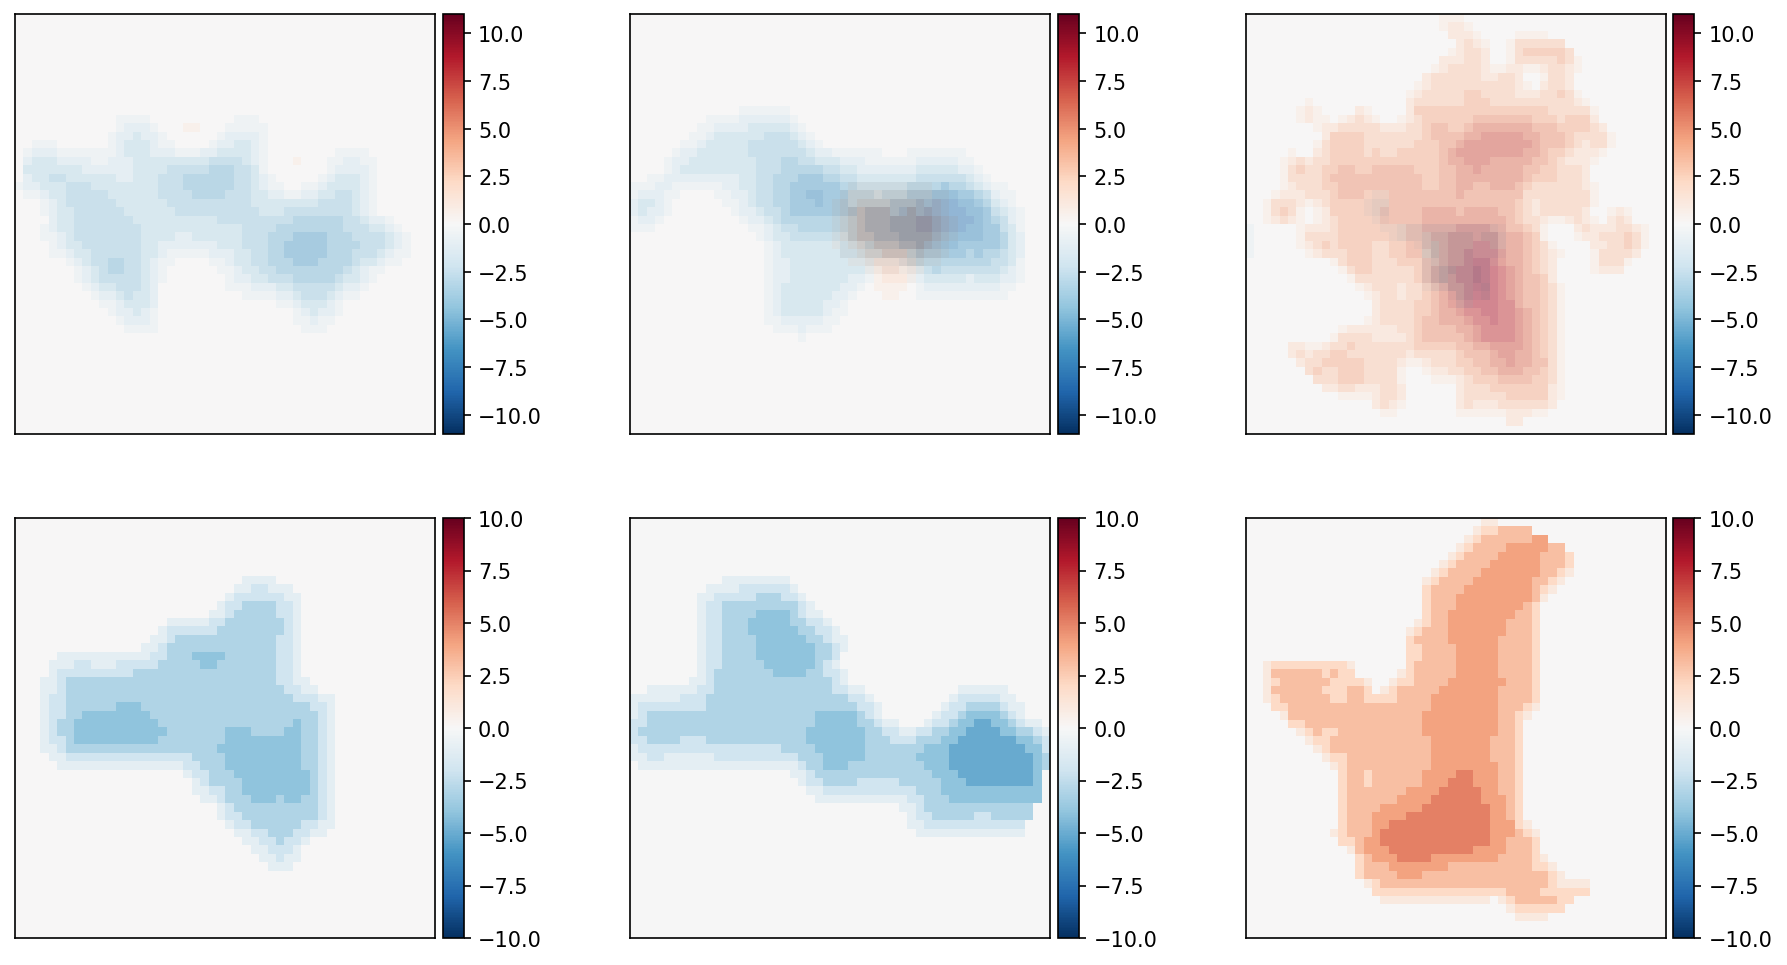

In [77]:
fig,axs = plt.subplots(2,3,figsize=(15,8),dpi=150)

for idx,Ldict in enumerate([L23_data,L4_data,L56_data]):
    data_id = np.argmax(Ldict['SR_OS'])
    pf.doubimshbar(fig,axs[0,idx],Ldict['SR_ON'][data_id],
                   -Ldict['SR_OF'][data_id],vmin=-10,vmax=10)
    pf.imshowbar(fig,axs[1,idx],Ldict['RF_ON'][data_id]-\
                 Ldict['RF_OF'][data_id],vmin=-10,vmax=10)